In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [116]:
df = pd.read_csv('../../data/5_genres_audio_features.tsv', delimiter='\t')
df.shape

(4998, 15)

In [117]:
df.head(5)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,1mWdTewIgB3gtBM3TOSFhB,0.759,0.459,8,-5.187,1,0.0948,0.00323,0.000000,0.0906,0.695,109.997,164442,4,pop
1,6A1IbMKwjvXibcrU1sdqKH,0.638,0.703,5,-6.413,0,0.1080,0.21300,0.000985,0.0927,0.289,180.008,197333,4,pop
2,5iZHnufFUgATzrpGgH1K0W,0.662,0.205,5,-14.005,0,0.0349,0.87600,0.003540,0.1090,0.268,139.911,260571,4,pop
3,4CUvVaAYuXtvYURLFz7EIL,0.517,0.467,0,-7.222,1,0.0442,0.72400,0.000000,0.0908,0.453,199.815,208049,3,pop
4,2EZtTS76x5M6hK96CLclPd,0.658,0.451,6,-7.721,1,0.0410,0.53100,0.000034,0.1220,0.472,179.862,258668,4,pop


In [118]:
raw_data = df.drop(['id'], axis=1)
data = raw_data.drop_duplicates().reset_index(drop=True)
data.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,0.759,0.459,8,-5.187,1,0.0948,0.00323,0.000000,0.0906,0.695,109.997,164442,4,pop
1,0.638,0.703,5,-6.413,0,0.1080,0.21300,0.000985,0.0927,0.289,180.008,197333,4,pop
2,0.662,0.205,5,-14.005,0,0.0349,0.87600,0.003540,0.1090,0.268,139.911,260571,4,pop
3,0.517,0.467,0,-7.222,1,0.0442,0.72400,0.000000,0.0908,0.453,199.815,208049,3,pop
4,0.658,0.451,6,-7.721,1,0.0410,0.53100,0.000034,0.1220,0.472,179.862,258668,4,pop


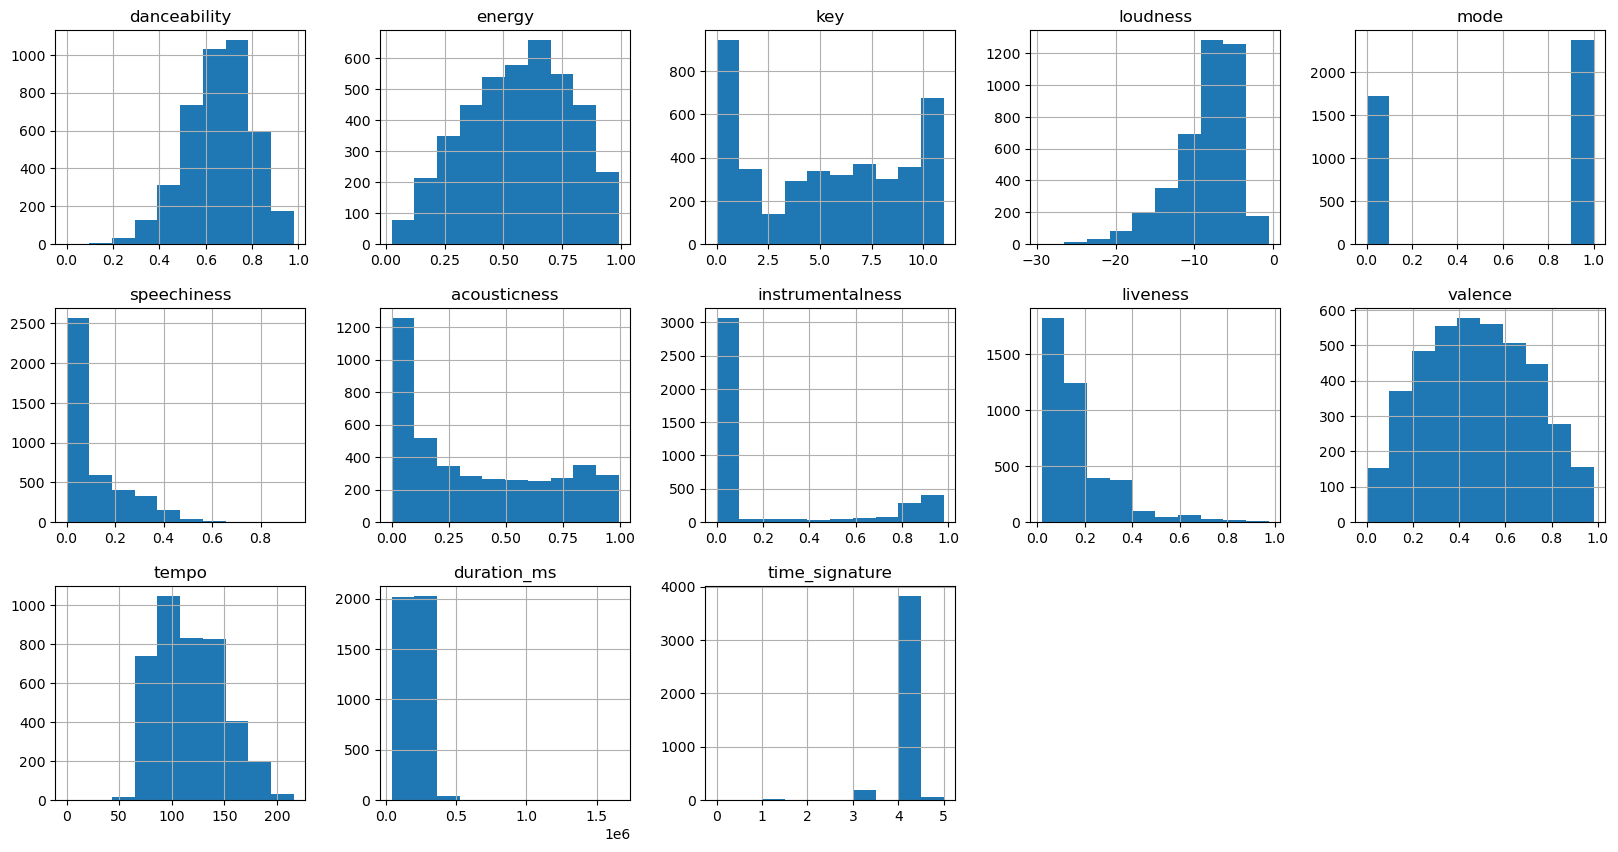

In [119]:
data.hist(layout=(3, 5), figsize=(20, 10))
plt.show()

In [120]:
data = data.sort_values(by=['genre'])

In [121]:
label = data['genre']
label.value_counts()

chillhop    997
hip hop     952
rock        768
pop         729
rap         643
Name: genre, dtype: int64

In [122]:
encoder = LabelEncoder()
y = encoder.fit_transform(label)
len(y)

4089

In [123]:
scaler = MinMaxScaler()
x = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
x.shape

(4089, 13)

In [124]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=20)

x_train.shape, x_test.shape

((3271, 13), (818, 13))

In [125]:
raw_test_data = pd.read_csv("../../data/audio_features_data.tsv", delimiter='\t')
raw_test_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
0,0.674,0.428,7,-9.504,1,0.1220,0.12100,0.000000,0.1320,0.337,84.878,2dLLR6qlu5UJ5gk0dKz0h3,190185,4,art pop
1,0.861,0.504,7,-7.707,1,0.0489,0.00412,0.000018,0.0783,0.881,120.000,5PUvinSo4MNqW7vmomGRS7,263053,4,contemporary r&b
2,0.781,0.526,6,-6.986,0,0.2930,0.06330,0.000000,0.0457,0.665,94.993,6CjtS2JZH9RkDz5UVInsa9,235613,4,dance pop
3,0.794,0.811,6,-8.966,0,0.0380,0.04260,0.000001,0.1010,0.862,116.047,2Foc5Q5nqNiosCNqttzHof,248413,4,electro
4,0.537,0.569,5,-8.046,1,0.3000,0.85500,0.000000,0.0909,0.524,78.907,2bYZxKw8wv9lGQjcskPRl3,135385,4,sad rap


In [126]:
test_data = raw_test_data.drop(['id'], axis=1)
test_data['genre'] = test_data['genre'].apply(lambda x: x.split(' ')[-1])
test_data.loc[test_data['genre'] == 'hop', 'genre'] = 'hip hop'
top5 = test_data['genre'].value_counts().nlargest(5).index.tolist()
top5

['pop', 'rock', 'hip hop', 'rap', 'chillhop']

In [127]:
test_data = test_data[test_data['genre'].isin(top5)]
test_data['genre'].value_counts()

pop         335
rock        206
hip hop     148
rap         104
chillhop     95
Name: genre, dtype: int64

In [128]:
test_data = test_data.sort_values(by=['genre'])

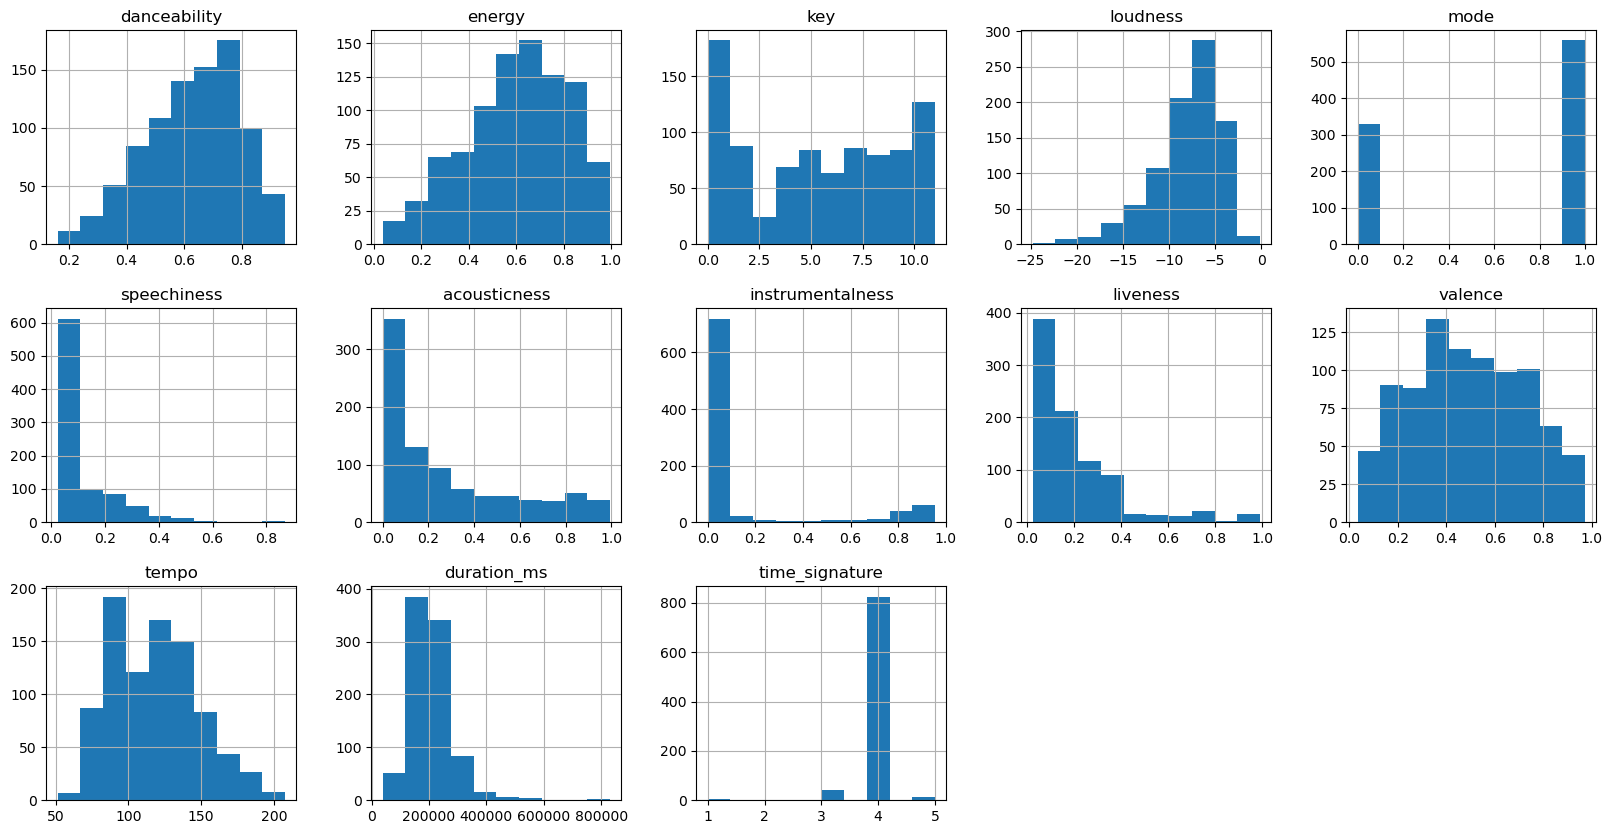

In [129]:
test_data.hist(layout=(3, 5), figsize=(20, 10))
plt.show()

In [130]:
x_test_2 = scaler.fit_transform(np.array(test_data.iloc[:, :-1], dtype = float))
x_test_2.shape

(888, 13)

In [131]:
y_test_2 = encoder.fit_transform(test_data['genre'])
len(y_test_2)

888

-------

In [132]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

import plotly.express as px

In [133]:
knn_model = KNeighborsClassifier()
dec_model = DecisionTreeClassifier()
mlp_model = MLPClassifier()
bayes_model = GaussianNB()
bagging_model = BaggingClassifier()

In [134]:
knn_model.fit(x_train, y_train)
dec_model.fit(x_train, y_train)
mlp_model.fit(x_train, y_train)
bayes_model.fit(x_train, y_train)
bagging_model.fit(x_train, y_train)

/home/sukivn/anaconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



BaggingClassifier()

In [135]:
knn_pred = knn_model.predict(x_test)
dec_pred = dec_model.predict(x_test)
mlp_pred = mlp_model.predict(x_test)
bayes_pred = bayes_model.predict(x_test)
bagging_pred = bagging_model.predict(x_test)

In [136]:
print("K-Nearest-Neighbors Evaluation Metrics:\n ", classification_report(y_test, knn_pred, labels=list(set(y_test))))

K-Nearest-Neighbors Evaluation Metrics:
                precision    recall  f1-score   support

           0       0.94      0.88      0.91       213
           1       0.60      0.61      0.61       191
           2       0.38      0.51      0.44       148
           3       0.28      0.30      0.29       103
           4       0.58      0.40      0.48       163

    accuracy                           0.58       818
   macro avg       0.56      0.54      0.54       818
weighted avg       0.60      0.58      0.59       818



In [137]:
print("Decision Tree Evaluation Metrics:\n ", classification_report(y_test, dec_pred, labels=list(set(y_test))))

Decision Tree Evaluation Metrics:
                precision    recall  f1-score   support

           0       0.88      0.89      0.88       213
           1       0.63      0.53      0.58       191
           2       0.42      0.39      0.40       148
           3       0.22      0.33      0.27       103
           4       0.59      0.55      0.57       163

    accuracy                           0.58       818
   macro avg       0.55      0.54      0.54       818
weighted avg       0.60      0.58      0.58       818



In [138]:
print("Neural Network Evaluation Metrics:\n ", classification_report(y_test, mlp_pred, labels=list(set(y_test))))


Neural Network Evaluation Metrics:
                precision    recall  f1-score   support

           0       0.95      0.90      0.92       213
           1       0.67      0.73      0.70       191
           2       0.52      0.51      0.52       148
           3       0.30      0.26      0.28       103
           4       0.68      0.72      0.70       163

    accuracy                           0.67       818
   macro avg       0.62      0.62      0.62       818
weighted avg       0.67      0.67      0.67       818



In [139]:
print("Bagging Algorithms Evaluation Metrics:\n ", classification_report(y_test, bayes_pred, labels=list(set(y_test))))

Bagging Algorithms Evaluation Metrics:
                precision    recall  f1-score   support

           0       0.92      0.90      0.91       213
           1       0.69      0.73      0.71       191
           2       0.45      0.64      0.53       148
           3       0.31      0.27      0.29       103
           4       0.67      0.45      0.54       163

    accuracy                           0.64       818
   macro avg       0.61      0.60      0.59       818
weighted avg       0.66      0.64      0.64       818



In [140]:
print("Support Vector Machine Evaluation Metrics:\n ", classification_report(y_test, bagging_pred, labels=list(set(y_test))))

Support Vector Machine Evaluation Metrics:
                precision    recall  f1-score   support

           0       0.92      0.92      0.92       213
           1       0.66      0.67      0.67       191
           2       0.48      0.47      0.47       148
           3       0.35      0.38      0.37       103
           4       0.72      0.69      0.71       163

    accuracy                           0.67       818
   macro avg       0.63      0.63      0.63       818
weighted avg       0.67      0.67      0.67       818



In [141]:
knn_acc = knn_model.score(x_test, y_test)
dec_acc = dec_model.score(x_test, y_test)
mlp_acc = mlp_model.score(x_test, y_test)
bayes_acc = bayes_model.score(x_test, y_test)
bagging_acc = bagging_model.score(x_test, y_test)

print("K-Nearest-Neighbors Accuracy:", knn_acc)
print("Decision Tree Accuracy:", dec_acc)
print("Neural Network Accuracy:", mlp_acc)
print("Bagging Algorithms Accuracy:", bagging_acc)
print("Support Vector Machine Accuracy:", bayes_acc)

K-Nearest-Neighbors Accuracy: 0.5831295843520783
Decision Tree Accuracy: 0.5770171149144254
Neural Network Accuracy: 0.6723716381418093
Bagging Algorithms Accuracy: 0.6674816625916871
Support Vector Machine Accuracy: 0.6430317848410758


In [142]:
fig = px.bar(
    x=["K-Nearest-Neighbors", "Decision Tree", "Neural Network", "Bagging Algorithms", "Gaussian Naive Bayes"],
    y=[knn_acc, dec_acc, mlp_acc, bagging_acc, bayes_acc],
    color=["K-Nearest-Neighbors", "Decision Tree", "Neural Network", "Bagging Algorithms", "Gaussian Naive Bayes"],
    labels={'x': "Model", 'y': "Accuracy"},
    title="Model Accuracy Comparison with Test data initialized from splitting"
)

fig.show()

In [143]:
knn_pred2 = knn_model.predict(x_test_2)
dec_pred2 = dec_model.predict(x_test_2)
mlp_pred2 = mlp_model.predict(x_test_2)
bayes_pred2 = bayes_model.predict(x_test_2)
bagging_pred2 = bagging_model.predict(x_test_2)

In [144]:
print("K-Nearest-Neighbors Evaluation Metrics:\n ", classification_report(y_test_2, knn_pred2, labels=list(set(y_test))))

K-Nearest-Neighbors Evaluation Metrics:
                precision    recall  f1-score   support

           0       0.56      0.87      0.68        95
           1       0.29      0.49      0.37       148
           2       0.54      0.27      0.36       335
           3       0.20      0.15      0.17       104
           4       0.46      0.54      0.50       206

    accuracy                           0.42       888
   macro avg       0.41      0.47      0.42       888
weighted avg       0.44      0.42      0.40       888



In [145]:
print("Decision Tree Evaluation Metrics:\n ", classification_report(y_test_2, dec_pred2, labels=list(set(y_test))))

Decision Tree Evaluation Metrics:
                precision    recall  f1-score   support

           0       0.55      0.43      0.49        95
           1       0.32      0.49      0.39       148
           2       0.57      0.24      0.34       335
           3       0.20      0.18      0.19       104
           4       0.39      0.67      0.49       206

    accuracy                           0.40       888
   macro avg       0.41      0.40      0.38       888
weighted avg       0.44      0.40      0.38       888



In [146]:
print("Neural Network Evaluation Metrics:\n ", classification_report(y_test_2, mlp_pred2, labels=list(set(y_test))))


Neural Network Evaluation Metrics:
                precision    recall  f1-score   support

           0       0.79      0.79      0.79        95
           1       0.37      0.74      0.49       148
           2       0.65      0.06      0.11       335
           3       0.55      0.06      0.10       104
           4       0.40      0.89      0.56       206

    accuracy                           0.44       888
   macro avg       0.55      0.51      0.41       888
weighted avg       0.55      0.44      0.35       888



In [147]:
print("Bagging Algorithms Evaluation Metrics:\n ", classification_report(y_test_2, bayes_pred2, labels=list(set(y_test))))

Bagging Algorithms Evaluation Metrics:
                precision    recall  f1-score   support

           0       0.65      0.85      0.74        95
           1       0.25      0.75      0.37       148
           2       0.43      0.06      0.10       335
           3       0.45      0.05      0.09       104
           4       0.42      0.51      0.46       206

    accuracy                           0.36       888
   macro avg       0.44      0.44      0.35       888
weighted avg       0.42      0.36      0.30       888



In [148]:
print("Support Vector Machine Evaluation Metrics:\n ", classification_report(y_test_2, bagging_pred2, labels=list(set(y_test))))

Support Vector Machine Evaluation Metrics:
                precision    recall  f1-score   support

           0       0.71      0.60      0.65        95
           1       0.36      0.64      0.46       148
           2       0.57      0.16      0.25       335
           3       0.19      0.08      0.11       104
           4       0.41      0.82      0.55       206

    accuracy                           0.43       888
   macro avg       0.45      0.46      0.40       888
weighted avg       0.47      0.43      0.38       888



In [149]:
knn_acc_2 = knn_model.score(x_test_2, y_test_2)
dec_acc_2 = dec_model.score(x_test_2, y_test_2)
mlp_acc_2 = mlp_model.score(x_test_2, y_test_2)
bayes_acc_2 = bayes_model.score(x_test_2, y_test_2)
bagging_acc_2 = bagging_model.score(x_test_2, y_test_2)

print("K-Nearest-Neighbors Accuracy:", knn_acc_2)
print("Decision Tree Accuracy:", dec_acc_2)
print("Neural Network Accuracy:", mlp_acc_2)
print("Bagging Algorithms Accuracy:", bagging_acc_2)
print("Support Vector Machine Accuracy:", bayes_acc_2)

K-Nearest-Neighbors Accuracy: 0.42004504504504503
Decision Tree Accuracy: 0.3952702702702703
Neural Network Accuracy: 0.4436936936936937
Bagging Algorithms Accuracy: 0.43018018018018017
Support Vector Machine Accuracy: 0.36373873873873874


In [150]:
fig = px.bar(
    x=["K-Nearest-Neighbors", "Decision Tree", "Neural Network", "Bagging Algorithms", "Gaussian Naive Bayes"],
    y=[knn_acc_2, dec_acc_2, mlp_acc_2, bagging_acc_2, bayes_acc_2],
    color=["K-Nearest-Neighbors", "Decision Tree", "Neural Network", "Bagging Algorithms", "Gaussian Naive Bayes"],
    labels={'x': "Model", 'y': "Accuracy"},
    title="Model Accuracy Comparison with New test data initialized"
)

fig.show()